In [ ]:
#default_exp modeling.seq2seq.translation

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.seq2seq.translation

> This module contains custom models, custom splitters, etc... translation tasks.

In [ ]:
# export
import inspect, torch
from typing import Callable, Dict, List, Optional, Union

from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.data.core import DataLoaders
from fastai.imports import *
from fastai.learner import *
from fastai.torch_core import *
from fastai.torch_imports import *
from fastcore.all import *
from transformers import AutoModelForSeq2SeqLM, PreTrainedModel, logging 

from blurr.utils import BLURR
from blurr.data.seq2seq.core import Seq2SeqBatchTokenizeTransform, Seq2SeqTextBlock, default_text_gen_kwargs
from blurr.modeling.core import BaseModelCallback, BaseModelWrapper, Blearner, PreCalculatedCrossEntropyLoss
from blurr.modeling.seq2seq.core import Seq2SeqMetricsCallback, blurr_seq2seq_splitter

logging.set_verbosity_error()

In [ ]:
# hide_input
import ast, os, inspect, pdb
from functools import reduce

from datasets import load_dataset
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, ranger, OptimWrapper, params
from fastcore.test import *
from nbdev.showdoc import show_doc

from blurr.utils import print_versions

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.10.1+cu111
fastai: 2.5.3
transformers: 4.16.2


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Mid-level API

### Prepare the data

### Example

The objective in translation is to generate a representation of a given text in another style. For example, we may want to translate German into English or modern English into old English.

In [ ]:
dataset = load_dataset('wmt16', 'de-en', split='train')
dataset = dataset.shuffle(seed=32).select(range(1200))
wmt_df = pd.DataFrame(dataset['translation'], columns=['de', 'en']); len(wmt_df)
wmt_df.head(2)

Reusing dataset wmt16 (/home/wgilliam/.cache/huggingface/datasets/wmt16/de-en/1.0.0/af3c5d746b307726d0de73ebe7f10545361b9cb6f75c83a1734c000e48b6264f)
Loading cached shuffled indices for dataset at /home/wgilliam/.cache/huggingface/datasets/wmt16/de-en/1.0.0/af3c5d746b307726d0de73ebe7f10545361b9cb6f75c83a1734c000e48b6264f/cache-8fc54b133c8c43b7.arrow


,de,en
0,"Tada se dio stanovništva preselio uz samu obalu - Pristan, gdje je i nastao Novi grad početkom XX vijeka.","In that period the majority of the population moved close to the seaside, where the first sea port was founded at the beginning of the 20th century, and later a new city was built."
1,"""Dieses Video ist nicht verfügbar loger"" bitch, daß das Böse, der sein Video auf YouTube hochgeladen hatte nearsyx?","""This video is no loger available"" that evil bitch, who had uploaded his video on youtube nearsyx?"


In [ ]:
pretrained_model_name = "Helsinki-NLP/opus-mt-de-en"
model_cls = AutoModelForSeq2SeqLM

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)
hf_arch, type(hf_tokenizer), type(hf_config), type(hf_model)

('marian',
 transformers.models.marian.tokenization_marian.MarianTokenizer,
 transformers.models.marian.configuration_marian.MarianConfig,
 transformers.models.marian.modeling_marian.MarianMTModel)

In [ ]:
blocks = (Seq2SeqTextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader('de'), get_y=ColReader('en'), splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(wmt_df, bs=2)

In [ ]:
b = dls.one_batch()

In [ ]:
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 168]), torch.Size([2, 140]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, input_trunc_at=250, target_trunc_at=250)

,text,target
0,"""In▁Erwägung▁nachstehender▁Gründe▁sollte das▁Europäische▁Parlament▁keinerlei▁Doppelmoral tolerieren. Indessen und um▁politischen Druck auf▁Journalisten▁auszuüben, die▁Korruptionsfälle aufdecken, die in▁Verbindung mit▁hochrangigen▁Beamten und▁regieren","'whereas the European Parliament shall not accept double standards; whereas, in order to put political pressure on journalists disclosing corruption cases linked to high-ranking officials and ruling party politicians, the Government administration in"
1,"▁Abschließend▁muss▁darauf▁hingewiesen▁werden,▁dass die▁frühere▁Verordnung des Rates Nr. 2371/2002 (EG), auf die in▁diesem▁Dokument▁Bezug▁genommen▁wird,▁darauf▁abzielte,▁bei der▁Umsetzung▁grundlegender▁Reformen in der Fischereipolitik▁Vorsicht walten","In conclusion, it should be pointed out that the intention of the earlier Council Regulation 2371/2002 mentioned in the document dealt with in the opinion was to retain the precautionary principle in connection with the introduction of fundamental ch"


#### Training

In [ ]:
seq2seq_metrics = {"bleu": {"returns": "bleu"}, "meteor": {"returns": "meteor"}, "sacrebleu": {"returns": "score"}}

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  #CrossEntropyLossFlat()
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

# learn = learn.to_native_fp16() #.to_fp16()
learn.freeze()


[nltk_data] Downloading package wordnet to /home/wgilliam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wgilliam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wgilliam/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#hide_output
# learn.summary()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds), preds["loss"].shape, preds["logits"].shape

(4, torch.Size([]), torch.Size([2, 140, 58101]))

In [ ]:
len(b), len(b[0]), b[0]["input_ids"].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([2, 168]), 2, torch.Size([2, 140]))

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(minimum=2.7542287170945203e-07, steep=1.5848931980144698e-06, valley=0.0003981071640737355, slide=0.00015848931798245758)

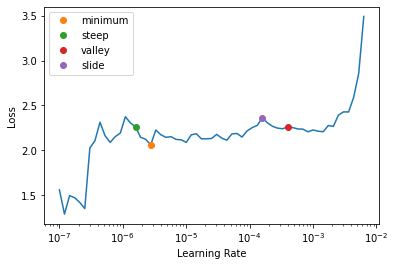

In [ ]:
#slow
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=4e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,2.192671,2.027766,0.307353,0.540451,29.957392,00:54


#### Showing results

And here we create a `@typedispatch`ed implementation of `Learner.show_results`.

In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=500)

,text,target,prediction
0,"Reyes Ruiz▁ist ein▁dummer Neuling, hat▁nur ein▁Narr in den▁Kopf,▁dass in▁einer ""rote"" Zone der▁Toleranz in▁diesen Momenten zu▁investieren,▁wenn Sie eine▁andere Art von▁Freizeiteinrichtungen für▁Jugendliche der Stadt,▁dass das▁Fehlen von▁Freizeit-Räume▁beginnen in▁Alkohol von▁einem▁frühen Alter,▁müssen wir▁Kinos,▁Einkaufszentren, etc,▁etwas▁gerichtet, um▁keinen▁Anreiz jovens▁Bereiche in▁denen die Prostitution yl▁Konsum▁alkoholischer▁Getränke, das▁ist▁mein▁Kommentar▁heute..","Reyes Ruiz is a stupid neophyte, only a fool has in his head that invest in a ""Red"" zone of tolerance in these moments when you need another type of recreational facilities for young people of the city that the lack of recreational spaces begin in alcohol from an early age, we need movie theaters, shopping malls, etc, something directed to jovens no incentive areas where prostitution yl consumption of alcoholic beverages, this is my comment today..","[Reyes Ruiz is a stupid novice who has just a fool in his head that in a ""red"" zone of tolerance to invest in these moments, if you have another type of leisure facilities for teens of the city that the lack of leisure spaces start in alcohol from an early age, we need cinemas, shopping malls, etc, something aimed at not encouraging jovens areas in which prostitution yl consumption of alcoholic beverages, that is my comment today .., (12) If, within the time limit laid down in paragraph 9, one or more competent national authority(s) cannot agree to the mutual recognition of the draft decision by the competent authority of the reference Member State, the procedure laid down in Article 35(2) of Directive 2001/83/EC or Article 39(2) of Directive 2001/82/EC shall apply.]"


#### Prediction

We add here `Learner.blurr_translate` method to bring the results inline with the format returned via Hugging Face's pipeline method

In [ ]:
test_de = "Ich trinke gerne Bier"

In [ ]:
outputs = learn.blurr_generate(test_de, key="translation_texts", num_return_sequences=3)
outputs

[{'translation_texts': ['I like to drink beer',
   'I like to drink beer.',
   'I like to drink']}]

In [ ]:
# export
@patch
def blurr_translate(self: Learner, inp, **kwargs):
    preds = learn.blurr_generate(inp, key="translation_texts", **kwargs)
    return preds

In [ ]:
learn.blurr_translate(test_de, num_return_sequences=3)

[{'translation_texts': ['I like to drink beer',
   'I like to drink beer.',
   'I like to drink']}]

#### Inference

Using fast.ai `Learner.export` and `load_learner`

In [ ]:
export_fname = 'translation_export'

In [ ]:
learn.metrics = None
learn.export(fname=f'{export_fname}.pkl')

In [ ]:
inf_learn = load_learner(fname=f'{export_fname}.pkl')
inf_learn.blurr_translate(test_de)

[{'translation_texts': 'I like to drink beer'}]

In [ ]:
#hide
try: del learn; del inf_learn; torch.cuda.empty_cache()
except: pass

## High-level API

### `BlearnerForTranslation`

We also introduce a task specific `Blearner` that get you your DataBlock, DataLoaders, and BLearner in one line of code!

In [ ]:
# export
@delegates(Blearner.__init__)
class BlearnerForTranslation(Blearner):
    def __init__(self, dls: DataLoaders, hf_model: PreTrainedModel, **kwargs):
        super().__init__(dls, hf_model, **kwargs)

    def predict(self, text, **kwargs):
        return self.blurr_translate(text, **kwargs)

    @classmethod
    def get_model_cls(cls):
        return AutoModelForSeq2SeqLM

    @classmethod
    def _add_t5_prefix(cls, inp, src_lang_name, trg_lang_name):
        return f"translate {src_lang_name} to {trg_lang_name}: {inp}"

    @classmethod
    def get_metrics_cb(self):
        seq2seq_metrics = {"bleu": {"returns": "bleu"}, "meteor": {"returns": "meteor"}, "sacrebleu": {"returns": "score"}}

        return Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)

    @classmethod
    def from_data(
        cls,
        # Your raw dataset. Supports DataFrames, Hugging Face Datasets, as well as file paths 
        # to .csv, .xlsx, .xls, and .jsonl files
        data: Union[pd.DataFrame, Path, str, List[Dict]],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # The language of your source (inputs)
        src_lang_name: str = "English",
        # The attribute/column of your source language texts
        src_lang_attr: str = "src_lang",
        # The attribute/column of your target language texts
        trg_lang_name: str = "English",
        # The attribute/column of your target language texts (this is what you want to predict)
        trg_lang_attr: str = "trg_lang",
        # The max length of your raw text to consider for summarization
        max_length: Union[int, str] = None,
        # The max length of your targets (sumamrized) text
        max_target_length: Union[int, str] = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Optional[Callable] = None,
        # Any additional keyword arguments applied during tokenization
        hf_tok_kwargs: dict = {},
        # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
        text_gen_kwargs: dict = {},
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs: dict = {},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs: dict = {},
    ):
        # if we get a path/str then we're loading something like a .csv file
        if isinstance(data, Path) or isinstance(data, str):
            content_type = mimetypes.guess_type(data)[0]
            if content_type  == 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet': 
                data = pd.read_excel(data)
            elif content_type  == 'text/csv': 
                data = pd.read_csv(data)
            elif content_type  == 'application/json': 
                data = pd.read_json(data, orient='records')
            else: 
                raise ValueError("'data' must be a .xlsx, .xls, .csv, or .jsonl file")

            data = pd.read_csv(data)

        # infer our datablock splitter if None
        if dblock_splitter is None:
            dblock_splitter = ColSplitter() if hasattr(data, "is_valid") else RandomSplitter()

        # we need to find the architecture to ensure "mbart" specific tokenizer kwargs are included
        model_cls = cls.get_model_cls()
        model = model_cls.from_pretrained(pretrained_model_name_or_path)
        hf_arch = BLURR.get_model_architecture(type(model).__name__)

        if hf_arch == "mbart":
            hf_tok_kwargs = {**{"src_lang": "en_XX", "tgt_lang": "en_XX"}, **hf_tok_kwargs}

        # get our hf objects
        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
            pretrained_model_name_or_path, model_cls=model_cls, tokenizer_kwargs=hf_tok_kwargs
        )

        # update text generation kwargs
        text_gen_kwargs = {**text_gen_kwargs, **default_text_gen_kwargs(hf_config, hf_model, task="translation")}

        # not all "translation" parameters are for the model.generate method ... remove them here
        generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
        for k in text_gen_kwargs.copy():
            if k not in generate_func_args:
                del text_gen_kwargs[k]

        # update our text generation kwargs for mbart
        if hf_arch == "mbart":
            text_gen_kwargs = {**{"decoder_start_token_id": "en_XX"}, **text_gen_kwargs}

        # build dblock, dls, and default metrics (optional)
        get_x = Pipeline(funcs=[ColReader(src_lang_attr)])
        get_y = ItemGetter(trg_lang_attr)

        if hf_arch == "t5":
            get_x.add(partial(cls._add_t5_prefix, src_lang_name=src_lang_name, trg_lang_name=trg_lang_name))

        batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
            hf_arch,
            hf_config,
            hf_tokenizer,
            hf_model,
            max_length=max_length,
            max_target_length=max_target_length,
            text_gen_kwargs=text_gen_kwargs,
        )

        blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)
        dblock = DataBlock(blocks=blocks, get_x=get_x, get_y=get_y, splitter=dblock_splitter)

        dls = dblock.dataloaders(data, **dl_kwargs.copy())

        # return BLearner instance
        learner_kwargs["splitter"] = learner_kwargs.pop("splitter", partial(blurr_seq2seq_splitter, arch=hf_arch))
        learner_kwargs["loss_func"] = learner_kwargs.pop("loss_func", PreCalculatedCrossEntropyLoss())
        return cls(dls, hf_model, **learner_kwargs.copy())


In [ ]:
learn = BlearnerForTranslation.from_data(wmt_df, 'Helsinki-NLP/opus-mt-de-en', 
                                              src_lang_name='German', src_lang_attr='de', 
                                              trg_lang_name='English', trg_lang_attr='en',
                                              dl_kwargs={'bs':2})

In [ ]:
metrics_cb = BlearnerForTranslation.get_metrics_cb()
learn.fit_one_cycle(1, lr_max=4e-5, cbs=[metrics_cb])

[nltk_data] Downloading package wordnet to /home/wgilliam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wgilliam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wgilliam/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,2.135929,2.162880,0.294676,0.534788,28.069091,00:57


In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"""In▁Erwägung▁nachstehender▁Gründe▁sollte das▁Europäische▁Parlament▁keinerlei▁Doppelmoral tolerieren. Indessen und um▁politischen Druck auf▁Journalisten▁auszuüben, die▁Korruptionsfälle aufdecken, die in▁Verbindung mit▁hochrangigen▁Beamten und▁regierenden▁Politikern der▁Partei▁stehen, hat die▁ungarische Staatsverwaltung vor Kurzem▁Schritte▁eingeleitet, um▁Strafverfahren▁gegen▁derartige▁Vertreter der Medien▁anzustrengen -▁nämlich▁gegen▁Herrn Tamás Pindroch, den▁Journalisten von Magyar Hírlap -,▁wob","'whereas the European Parliament shall not accept double standards; whereas, in order to put political pressure on journalists disclosing corruption cases linked to high-ranking officials and ruling party politicians, the Government administration in","[""The European Parliament should not tolerate any double standards, however, and in order to exert political pressure on journalists to expose corruption cases related to high-ranking officials and political leaders of the Party, the Hungarian State Administration has recently taken steps to bring criminal proceedings against such media representatives, namely Mr Tamás Pindroch, the journalist of Magyar Hírlap, taking particular account of the fact that criminal proceedings have been launched against the journalist who has been investigating scandals related to senior former members of the government and one of the candidates for the office of European Commissioner., To this end, it is important to revolutionise the methods in order to achieve a significantly higher reach and effectiveness than the policies of the past. The Member States of the European Union, but also the candidate countries, in cooperation with the European Commission, must take all appropriate measures to disseminate the best practice and adopt those new models which are the success of the leading states.]"


In [ ]:
test_de = "Ich trinke gerne Bier"

In [ ]:
learn.blurr_translate(test_de)

[{'translation_texts': 'I like to drink beer'}]

In [ ]:
export_fname = 'translation_export'

learn.metrics = None
learn = learn.to_fp32()
learn.export(fname=f'{export_fname}.pkl')

inf_learn = load_learner(fname=f'{export_fname}.pkl')
inf_learn.blurr_generate(test_de)

[{'generated_texts': 'I like to drink beer'}]

## Tests

The purpose of the following tests is to ensure as much as possible, that the core training code works for the pretrained **translation models** below.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained summarization models you are working with ... and if any of your pretrained translation models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
[ model_type for model_type in BLURR.get_models(task='ConditionalGeneration') 
 if (not model_type.startswith('TF')) ]

['BartForConditionalGeneration',
 'BigBirdPegasusForConditionalGeneration',
 'BlenderbotForConditionalGeneration',
 'BlenderbotSmallForConditionalGeneration',
 'FSMTForConditionalGeneration',
 'LEDForConditionalGeneration',
 'M2M100ForConditionalGeneration',
 'MBartForConditionalGeneration',
 'MT5ForConditionalGeneration',
 'PegasusForConditionalGeneration',
 'ProphetNetForConditionalGeneration',
 'Speech2TextForConditionalGeneration',
 'T5ForConditionalGeneration',
 'XLMProphetNetForConditionalGeneration']

In [ ]:
pretrained_model_names = [
    'facebook/bart-base',
    'facebook/wmt19-de-en',                      # FSMT
    'Helsinki-NLP/opus-mt-de-en',                # MarianMT
    #'sshleifer/tiny-mbart',
    #'google/mt5-small',
    't5-small'
]

In [ ]:
dataset = load_dataset('wmt16', 'de-en', split='train')
dataset = dataset.shuffle(seed=32).select(range(1200))
wmt_df = pd.DataFrame(dataset['translation'], columns=['de', 'en']); len(wmt_df)

Reusing dataset wmt16 (/home/wgilliam/.cache/huggingface/datasets/wmt16/de-en/1.0.0/af3c5d746b307726d0de73ebe7f10545361b9cb6f75c83a1734c000e48b6264f)
Loading cached shuffled indices for dataset at /home/wgilliam/.cache/huggingface/datasets/wmt16/de-en/1.0.0/af3c5d746b307726d0de73ebe7f10545361b9cb6f75c83a1734c000e48b6264f/cache-8fc54b133c8c43b7.arrow


1200

In [ ]:
#slow
#hide_output
model_cls = AutoModelForSeq2SeqLM
bsz = 2
inp_seq_sz = 128; trg_seq_sz = 128

test_results = []
for model_name in pretrained_model_names:
    error=None
    
    print(f'=== {model_name} ===\n')
    
    hf_tok_kwargs = {}
    if (model_name == 'sshleifer/tiny-mbart'):
        hf_tok_kwargs['src_lang'], hf_tok_kwargs['tgt_lang'] = "de_DE", "en_XX"
            
    
    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(model_name, 
                                                                      model_cls=model_cls, 
                                                                      tokenizer_kwargs=hf_tok_kwargs)
    
    print(f'architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n')
    
    # 1. build your DataBlock
    text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='translation')
    
    def add_t5_prefix(inp): return f'translate German to English: {inp}' if (hf_arch == 't5') else inp
    
    batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                      padding='max_length', 
                                                      max_length=inp_seq_sz, 
                                                      max_target_length=trg_seq_sz, 
                                                      text_gen_kwargs=text_gen_kwargs)
    
    blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)
    dblock = DataBlock(blocks=blocks, 
                   get_x=Pipeline([ColReader('de'), add_t5_prefix]), 
                   get_y=ColReader('en'), 
                   splitter=RandomSplitter())

    dls = dblock.dataloaders(wmt_df, bs=bsz) 
    b = dls.one_batch()

    # 2. build your Learner
    seq2seq_metrics = {}
    
    model = BaseModelWrapper(hf_model)
    fit_cbs = [
        ShortEpochCallback(0.05, short_valid=True), 
        Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)
    ]

    learn = Learner(dls, 
                    model,
                    opt_func=ranger,
                    loss_func=PreCalculatedCrossEntropyLoss(),
                    cbs=[BaseModelCallback],
                    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch)).to_fp16()

    learn.create_opt() 
    learn.freeze()
    
    # 3. Run your tests
    try:
        print('*** TESTING DataLoaders ***\n')
        test_eq(len(b), 2)
        test_eq(len(b[0]['input_ids']), bsz)
        test_eq(b[0]['input_ids'].shape, torch.Size([bsz, inp_seq_sz]))
        test_eq(len(b[1]), bsz)

#         print('*** TESTING One pass through the model ***')
#         preds = learn.model(b[0])
#         test_eq(preds[1].shape[0], bsz)
#         test_eq(preds[1].shape[2], hf_config.vocab_size)

        print('*** TESTING Training/Results ***')
        learn.fit_one_cycle(1, lr_max=1e-3, cbs=fit_cbs)

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'PASSED', ''))
        learn.show_results(learner=learn, max_n=2, input_trunc_at=500, target_trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'FAILED', err))
    finally:
        # cleanup
        del learn; torch.cuda.empty_cache()

=== facebook/bart-base ===

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Zudem haben wir unser Augenmerk auf das Erfordernis einer größtmöglichen Harmonisierung der einzelstaatlichen Sozialvorschriften im Straßenverkehr, die sich dank der modernen Technologien bietenden Kontrollmöglichkeiten, die uns zur Verfügung stehenden statistischen Daten, die bereits geäußerten Ansichten des Europäischen Parlaments z","We also took account of the need for maximum possible harmonisation between social provisions in the field of road transport in the Member States, the opportunities offered by modern technology in connection with the subject of controls, the statist","[ Zudem haben wir unser Augenmerk auf das, Wenn wir uns den enormen Berg von Arbeit vor Augen hal]"


=== facebook/wmt19-de-en ===

architecture:	fsmt
tokenizer:	FSMTTokenizer
model:		FSMTForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"""In Erwägung nachstehender Gründe sollte das Europäische Parlament keinerlei Doppelmoral tolerieren. Indessen und um politischen Druck auf Journalisten auszuüben, die Korruptionsfälle aufdecken, die in Verbindung mit hochrangigen Beamten und regierenden Politikern der Partei stehen, hat die ungarische Staatsverwaltung vor Kurzem Schritte eingeleitet, um Strafverfahren gegen derartige Vertreter der Medien anzustrengen - nämlich gegen Herrn Tamás Pindroch, den Journalisten von Magyar Hírlap -, wob","'whereas the European Parliament shall not accept double standards; whereas, in order to put political pressure on journalists disclosing corruption cases linked to high-ranking officials and ruling party politicians, the Government administration in","[""Considering the following reasons, the European Parliament should not tolerate any double standards. However, and in order to exert political pressure on journalists who expose cases of corruption linked to senior officials and ruling politicians of the party, the Hungarian State Administration has recently taken steps to bring criminal proceedings against such representatives of the media - namely against Mr Tamás Pindroch, the journalist of Magyar Hírlap - taking into account in particular the fact that criminal proceedings have been opened against the journalist who investigated scandals,, As the Portuguese Presidency has pointed out, the European Union needs to better reconcile its extremely important role as the world's largest donor with a leading and more active role in this movement for a renewal of development policy on an international scale and to develop its capacity for linking and coordinating, particularly with the United Nations system and the Bretton Woods system.]"


=== Helsinki-NLP/opus-mt-de-en ===

architecture:	marian
tokenizer:	MarianTokenizer
model:		MarianMTModel

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"▁Schließen die▁vorgeschlagenen▁Anwendungszwecke▁Empfehlungen über die▁Bekämpfung von oder den▁Schutz▁gegen▁Organismen ein, die▁unter den in der▁vorgesehenen▁Anwendungsregion▁herrschenden▁Bedingungen in▁bezug auf▁Landwirtschaft,▁Pflanzenschutz und Umwelt -▁einschließlich der▁Witterungsverhältnisse - nach den▁Erfahrungen und dem▁wissenschaftlichen▁Erkenntnisstand nicht▁als▁schädlich▁gelten, oder▁ist▁davon▁auszugehen,▁daß die▁anderen▁Wirkungen▁unter▁diesen▁Bedingungen den▁beabsichtigten▁Zweck nicht","Where relevant, yield response when the product is used and reduction of loss in storage must be quantitatively and/or qualitatively similar to those resulting from the use of suitable reference products. If no suitable reference product exists, the","[Where the proposed uses include recommendations on the control of or protection against organisms which are not considered harmful under the conditions prevailing in the intended application region in respect of agriculture, plant health and the environment, including climatic conditions, in the light of experience and scientific knowledge, or where it is considered that the other effects do not meet the intended purpose under these conditions, no authorisation shall be granted for such uses., This is by no means intended to deny the importance of traditional energy sources - and I could do so even less at the moment when Algerian gas comes to Spain and from Spain to Portugal and to the rest of Europe via such an important construction as the gas pipeline linking Algeria to our continent and our Union via Morocco, but of course the emphasis this report places on renewable and sustainable energy sources and energy saving is greatly appreciated.]"


=== t5-small ===

architecture:	t5
tokenizer:	T5TokenizerFast
model:		T5ForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"translate German to English: Ich habe das Glück hier zu stehen, als schwuler Mann - und wenn ich für mich beschlossen habe, schwul zu sein, ist es nicht interessant, dass jemand anderes offensichtlich für sich bestimmt, heterosexuell zu sein? - Kampf für die Gleichstellung, nicht nur für schwule Männer und Lesben und Bisexuelle und Transgender, sondern für Menschen auf Grund ihres Alters, ihrer Religion, ihres Glauben, ihres Geschlechts, alles, was als Unterschied wahrgenommen wird","I stand here fortunate, as a gay man - and if I chose to be gay, is it not interesting that one obviously therefore chooses to be heterosexual? - fighting for equality, not just for gay men and lesbians and bisexuals and transgender people, but for p","[Ich habe das Glück hier zu stehen, als schwuler Mann - und wenn , In der begrenzten Zeit, die mir gewährt wird, Herr Präsident,]"


In [ ]:
#slow
#hide_input
test_results_df = pd.DataFrame(test_results, columns=['arch', 'tokenizer', 'model_name', 'result', 'error'])
display_df(test_results_df)

,arch,tokenizer,model_name,result,error
0,bart,BartTokenizerFast,BartForConditionalGeneration,PASSED,
1,fsmt,FSMTTokenizer,FSMTForConditionalGeneration,PASSED,
2,marian,MarianTokenizer,MarianMTModel,PASSED,
3,t5,T5TokenizerFast,T5ForConditionalGeneration,PASSED,


## Summary

This module includes the fundamental bits to use Blurr for translation tasks training and inference.

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted 99e_examples-causal-lm-gpt2.ipynb.
Converted index.ipynb.
